In [25]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [26]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])


In [27]:
train_dataset = datasets.ImageFolder(root='train 70001', transform=transform)
val_dataset = datasets.ImageFolder(root='Validation 19000', transform=transform)
test_dataset = datasets.ImageFolder(root='test 5413', transform=transform)


In [28]:
# def get_subset(dataset, percentage=0.1):
#     total_size = len(dataset)
#     subset_size = int(percentage * total_size)
#     _, subset = random_split(dataset, [total_size - subset_size, subset_size])
#     return subset

from torch.utils.data import Subset
import random

def get_subset(dataset, num_images):
    # Ensure num_images does not exceed the size of the dataset
    if num_images > len(dataset):
        raise ValueError(f"Requested {num_images} images, but dataset only has {len(dataset)} images.")
    
    # Get random indices from the dataset
    indices = random.sample(range(len(dataset)), num_images)
    
    # Return the subset
    return Subset(dataset, indices)

In [29]:
train_subset = get_subset(train_dataset, num_images=500)
val_subset = get_subset(val_dataset, num_images=500)
test_subset = get_subset(test_dataset, num_images=500)

In [30]:
batch_size = 64

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)


In [31]:
import matplotlib.pyplot as plt
from PIL import Image

def show_images(images, labels, class_names, num_images=25):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.show()

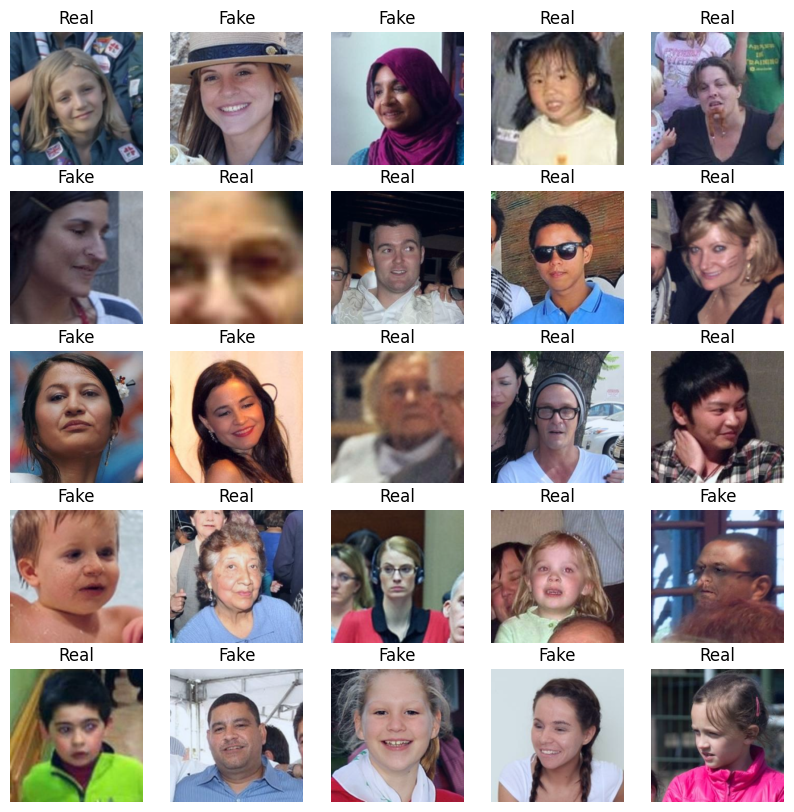

In [32]:
images, labels = next(iter(train_loader))
class_names = train_dataset.classes
show_images(images, labels, class_names)

In [33]:
import torch.nn as nn
import torchvision.models as models

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [35]:
criterion = nn.CrossEntropyLoss()


In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [37]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}, Accuracy: {100*correct/total}%')


Epoch [1/10], Loss: 0.6638038083910942, Accuracy: 72.2%
Epoch [2/10], Loss: 0.2095037493854761, Accuracy: 92.2%
Epoch [3/10], Loss: 0.08922483422793448, Accuracy: 97.6%
Epoch [4/10], Loss: 0.07877472462132573, Accuracy: 97.6%
Epoch [5/10], Loss: 0.03013257193379104, Accuracy: 99.4%
Epoch [6/10], Loss: 0.025167676503770053, Accuracy: 99.6%
Epoch [7/10], Loss: 0.009942449018126354, Accuracy: 99.8%
Epoch [8/10], Loss: 0.005576346578891389, Accuracy: 100.0%
Epoch [9/10], Loss: 0.0045515008678194135, Accuracy: 100.0%
Epoch [10/10], Loss: 0.0007605144928675145, Accuracy: 100.0%


In [38]:
model.eval()
val_loss = 0.0
correct = 0
total = 0

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Store labels and predictions for advanced metrics
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())



In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
accuracy = 100 * correct / total

# Compute advanced metrics
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')
f1 = f1_score(all_labels, all_predictions, average='macro')
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Print the evaluation metrics
print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

Validation Loss: 0.4350, Validation Accuracy: 86.20%
Precision: 0.8621, Recall: 0.8629, F1-Score: 0.8619
Confusion Matrix:
[[221  41]
 [ 28 210]]


In [40]:
torch.save(model.state_dict(), 'deepfake_model_resnet.pth')


C:\Users\prith\AppData\Local\Temp\ipykernel_26032\1166181823.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('deepfake_model_resnet.pth

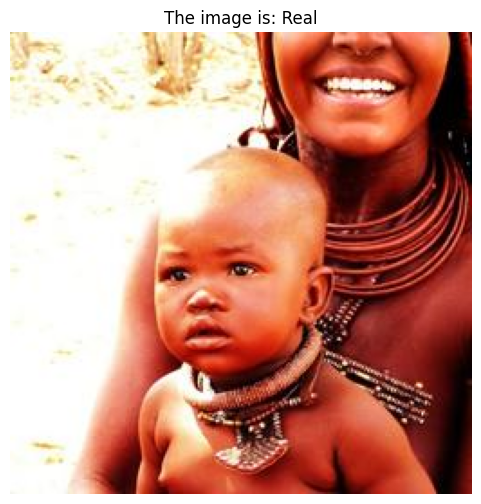

In [42]:
import torch
from torchvision import transforms
from PIL import Image
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Binary classification: real vs fake
model.load_state_dict(torch.load('deepfake_model_resnet.pth'))
model = model.to(device)
model.eval()

# Define the function to make predictions and display the image
def predict_and_show_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')  # Ensure image is in RGB mode
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Make prediction
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        output = model(image_tensor)
        _, predicted = output.max(1)
    
    # Map the prediction to class names
    class_names = ['Fake', 'Real']  # Assuming '0' is 'Fake' and '1' is 'Real'
    predicted_class = class_names[predicted.item()]

    # Display the image and prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(np.array(image))
    plt.title(f'The image is: {predicted_class}')
    plt.axis('off')
    plt.show()

# Example usage
image_path = 'Validation 19000/Real/real_2.jpg'
predict_and_show_image(image_path)


In [78]:
import torch
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Define MesoNet architecture
class MesoNet(nn.Module):
    def __init__(self):
        super(MesoNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(16 * 14 * 14, 16)  # Assuming input image size is 224x224
        self.fc2 = nn.Linear(16, 2)  # Binary classification: real vs fake

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MesoNet()  # Use MesoNet instead of ResNet
model.load_state_dict(torch.load('deepfake_model3_mesonet.pth'))  # Load your trained weights
model = model.to(device)
model.eval()

# Define the function to make predictions and display the image
def predict_and_show_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')  # Ensure image is in RGB mode
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Make prediction
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        output = model(image_tensor)
        _, predicted = output.max(1)
    
    # Map the prediction to class names
    class_names = ['Fake', 'Real']  # Assuming '0' is 'Fake' and '1' is 'Real'
    predicted_class = class_names[predicted.item()]

    # Display the image and prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(np.array(image))
    plt.title(f'The image is: {predicted_class}')
    plt.axis('off')
    plt.show()

# Example usage
image_path = 'val_sample_150/real/real_9911.jpg'
predict_and_show_image(image_path)


C:\Users\prith\AppData\Local\Temp\ipykernel_35616\4198482967.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('deepfake_model3_mesonet.p

RuntimeError: Error(s) in loading state_dict for MesoNet:
	Missing key(s) in state_dict: "conv1.0.weight", "conv1.0.bias", "conv1.1.weight", "conv1.1.bias", "conv1.1.running_mean", "conv1.1.running_var", "conv2.0.weight", "conv2.0.bias", "conv2.1.weight", "conv2.1.bias", "conv2.1.running_mean", "conv2.1.running_var", "conv3.0.weight", "conv3.0.bias", "conv3.1.weight", "conv3.1.bias", "conv3.1.running_mean", "conv3.1.running_var", "conv4.0.weight", "conv4.0.bias", "conv4.1.weight", "conv4.1.bias", "conv4.1.running_mean", "conv4.1.running_var", "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias". 
	Unexpected key(s) in state_dict: "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn1.num_batches_tracked", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.bn1.num_batches_tracked", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.bn2.num_batches_tracked", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.bn1.num_batches_tracked", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.bn2.num_batches_tracked", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.bn1.num_batches_tracked", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.bn2.num_batches_tracked", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.0.downsample.1.num_batches_tracked", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.bn1.num_batches_tracked", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.bn2.num_batches_tracked", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.bn1.num_batches_tracked", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.bn2.num_batches_tracked", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.0.downsample.1.num_batches_tracked", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.bn1.num_batches_tracked", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.bn2.num_batches_tracked", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.bn1.num_batches_tracked", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.bn2.num_batches_tracked", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.0.downsample.1.num_batches_tracked", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.bn1.num_batches_tracked", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.bn2.num_batches_tracked", "fc.weight", "fc.bias", "conv1.weight". 

In [7]:
import cv2
import dlib
import matplotlib.pyplot as plt

def align_face(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Initialize dlib's face detector and shape predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(dlib.shape_predictor('shape_predictor_68_face_landmarks.dat'))
    
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = detector(gray)
    
    for face in faces:
        landmarks = predictor(gray, face)
        
        for n in range(68):
            x, y = landmarks.part(n).x, landmarks.part(n).y
            cv2.circle(image, (x, y), 2, (0, 255, 0), -1)
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Face Alignment')
    plt.axis('off')
    plt.show()

# Example usage
image_path = 'Screenshot 2024-09-08 173218.png'
align_face(image_path)


ModuleNotFoundError: No module named 'dlib'

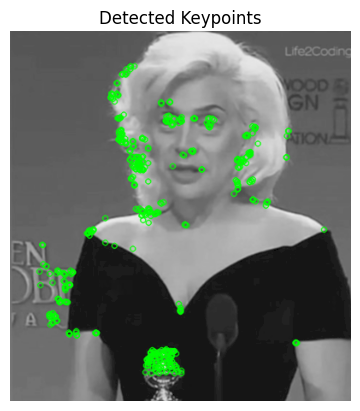

In [9]:
import cv2
import numpy as np

def match_face_features(image_path):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Initialize ORB detector
    orb = cv2.ORB_create()
    
    # Find keypoints and descriptors
    keypoints, descriptors = orb.detectAndCompute(image, None)
    
    # Draw keypoints
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0))
    
    plt.imshow(image_with_keypoints, cmap='gray')
    plt.title('Detected Keypoints')
    plt.axis('off')
    plt.show()

# Example usage
image_path = 'Screenshot 2024-09-08 173218.png'
match_face_features(image_path)


In [10]:
import cv2
import numpy as np

def analyze_light_shadow(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
    mean_brightness = np.mean(image)
    std_brightness = np.std(image)

    print(f"Mean Brightness: {mean_brightness}")
    print(f"Standard Deviation of Brightness: {std_brightness}")

    # Optionally, visualize the brightness distribution
    plt.hist(image.ravel(), bins=256, histtype='step')
    plt.title('Brightness Histogram')
    plt.xlabel('Brightness')
    plt.ylabel('Frequency')
    plt.show()


Mean Brightness: 99.85693448401605
Standard Deviation of Brightness: 55.38353839303393


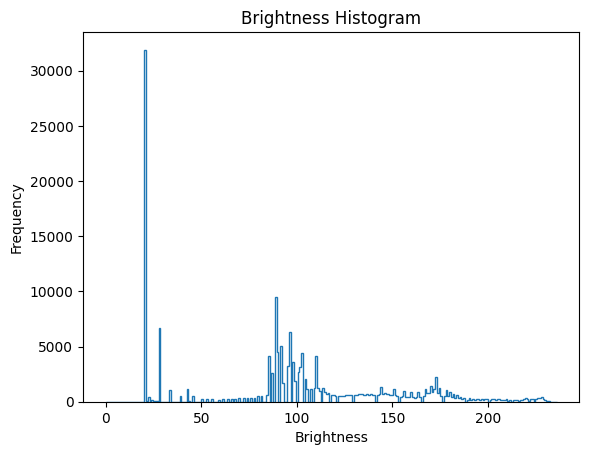

In [11]:
from torchvision import datasets, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define augmentations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load and apply transformations


# Analyze and visualize
image_path = 'Screenshot 2024-09-08 173218.png'
analyze_light_shadow(image_path)
